https://chat.openai.com/share/98bd9fe3-f8ae-4ff4-859a-dd4a7855c429

In [2]:
from dendropy.simulate import treesim
import dendropy
from Bio import Phylo
from io import StringIO
import Bio.Phylo.BaseTree
import numpy as np
import random
import matplotlib.pyplot as plt
import torch 
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Generate birth death trees

In [18]:
#birth_death_tree returns a tree generated under a continuous-time birth-death process, with branch lengths in arbitrary time units.
t_cont= treesim.birth_death_tree(birth_rate=0.8, death_rate=0.5, num_total_tips=15, repeat_until_success=True)
t_cont.print_plot()

                                      /------------------------------------- T1
                   /------------------+                                        
                   |                  |                  /------------------ T4
/------------------+                  \------------------+                     
|                  |                                     \------------------ T6
|                  |                                                           
|                  \-------------------------------------------------------- T8
+                                                                              
|                                     /------------------------------------- T7
|                  /------------------+                                        
|                  |                  |                  /------------------ T5
\------------------+                  \------------------+                     
                   |                    

# Convert to Newick string

In [19]:
newick_str = t_cont.as_string(schema="newick")
file = StringIO(newick_str)
bio_phylo_tree = Phylo.read(file, "newick")

# Get node living data

In [20]:
def get_living_times(tree, node, name_num=0, Dist = {}):
    if node == tree.root:
        node.name = "C"+str(name_num)
        Dist[node.name] = [0,0]
    if len(node.clades)!=0:
        for child in node.clades:
            if (child.name==None):
                child.name = "C"+ str(name_num)
                name_num += 1
            dist = Dist[node.name][1]
            Dist[child.name] = [dist,dist + child.branch_length]
            get_living_times(tree, child, name_num+1)
    return Dist

In [21]:
print(get_living_times(bio_phylo_tree, bio_phylo_tree.root))

{'C0': [0, 0.05606858124332878], 'C2': [0.05606858124332878, 1.6475759847688436], 'T1': [1.6475759847688436, 2.8199972567139975], 'C4': [1.6475759847688436, 2.8199972567139975], 'T4': [2.8199972567139975, 2.8199972567139975], 'T6': [2.8199972567139975, 2.8199972567139975], 'T8': [0.05606858124332878, 2.819997256713997], 'C1': [0.05606858124332878, 1.0949433498389933], 'C3': [1.0949433498389933, 2.2236972750523227], 'T7': [2.2236972750523227, 2.8760658379573267], 'C5': [2.2236972750523227, 2.5119781523157756], 'T5': [2.5119781523157756, 2.8760658379573267], 'T3': [2.5119781523157756, 2.8760658379573267], 'T2': [1.0949433498389933, 2.8760658379573263]}


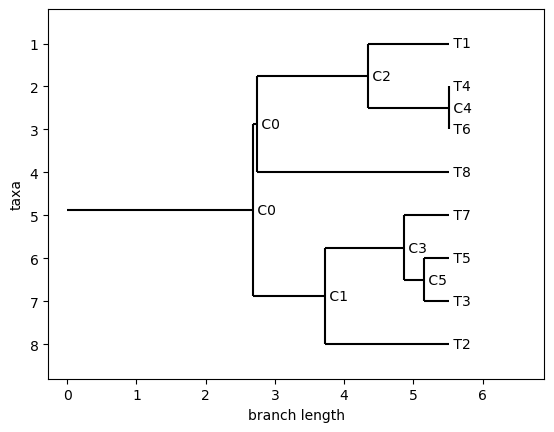

In [22]:
Phylo.draw(bio_phylo_tree)

# Collapse Tree - Trial run

In [23]:
#just using arbitrary bias and weights rn for testing
bias = np.array([[1],[1]])
weights = np.array([[0.5,0.1, 0.2, 0.2],[0.3,0.2, 0.1, 0.6]])
living_dict = get_living_times(bio_phylo_tree, bio_phylo_tree.root)

#turn dictionary of birth & death of nodes in list format into np vector format
def vectorize_dict(D):
    for node, [birth, death] in D.items():
        D[node] = np.array([birth, death]).reshape(2, 1)
    return D

living_dict = vectorize_dict(living_dict)
print(living_dict)

{'C0': array([[0.        ],
       [0.05606858]]), 'C2': array([[0.05606858],
       [1.64757598]]), 'T1': array([[1.64757598],
       [2.81999726]]), 'C4': array([[1.64757598],
       [2.81999726]]), 'T4': array([[2.81999726],
       [2.81999726]]), 'T6': array([[2.81999726],
       [2.81999726]]), 'T8': array([[0.05606858],
       [2.81999726]]), 'C1': array([[0.05606858],
       [1.09494335]]), 'C3': array([[1.09494335],
       [2.22369728]]), 'T7': array([[2.22369728],
       [2.87606584]]), 'C5': array([[2.22369728],
       [2.51197815]]), 'T5': array([[2.51197815],
       [2.87606584]]), 'T3': array([[2.51197815],
       [2.87606584]]), 'T2': array([[1.09494335],
       [2.87606584]])}


In [24]:
# collapse all living times to 1 vector
def collapse_tree(living_dict, tree, node):
    if len(node.clades)==0:
        #leaf node
        return living_dict[node.name]
    else:
        result = np.concatenate((collapse_tree(living_dict, tree, node.clades[0]), collapse_tree(living_dict, tree, node.clades[1])), axis=0)
        print(result)
        return np.add(np.matmul(weights,result), bias)

In [25]:
print(collapse_tree(living_dict, bio_phylo_tree, bio_phylo_tree.root))

[[2.81999726]
 [2.81999726]
 [2.81999726]
 [2.81999726]]
[[1.64757598]
 [2.81999726]
 [3.81999726]
 [4.38399671]]
[[3.74658651]
 [5.07067   ]
 [0.05606858]
 [2.81999726]]
[[2.51197815]
 [2.87606584]
 [2.51197815]
 [2.87606584]]
[[2.22369728]
 [2.87606584]
 [3.62120446]
 [4.30564393]]
[[3.9848249 ]
 [5.18782915]
 [1.09494335]
 [2.87606584]]
[[3.95557342]
 [4.83571516]
 [4.3053972 ]
 [5.06814714]]
[[5.3360671 ]
 [6.62524306]]


# Generate tree dataset

In [26]:
simulated_trees = []
matching_parameters = []
MIN_LEAVES = 10
MAX_LEAVES = 100


for i in range(0,10):
    rate_birth = random.random()
    rate_death = random.random()
    num_leaves = random.randint(MIN_LEAVES,MAX_LEAVES)
    t_cont= treesim.birth_death_tree(birth_rate=1.0, death_rate=rate_death, num_total_tips=num_leaves,repeat_until_success=True)
    simulated_trees.append(t_cont)
    matching_parameters.append([rate_birth,rate_death])
    print([rate_birth,rate_death])

[0.41961696362918166, 0.10903875197464119]
[0.12095190703622138, 0.577594844786388]
[0.22237850722817287, 0.5763956480863308]
[0.23643644825646082, 0.412845030929506]
[0.26068873499528455, 0.5579658690563494]
[0.9112034238289912, 0.48251942864317854]
[0.07657556421299305, 0.03924703176166722]
[0.5666497656397669, 0.4325999065212748]
[0.7827474245518065, 0.6034155145513278]
[0.9261345043790367, 0.9518277010163817]


In [27]:
bio_phylo_simulated_trees = []

#convert newick trees into bio phylo tree objects
for tree in simulated_trees:
    newick_str = tree.as_string(schema="newick")
    file = StringIO(newick_str)
    bio_phylo_tree = Phylo.read(file, "newick")
    bio_phylo_simulated_trees.append(bio_phylo_tree)
    

In [28]:
x,y = bio_phylo_simulated_trees, matching_parameters

y=np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=5)
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))
y_train.requires_grad_(True)
y_test.requires_grad_(True)

tensor([[0.9261, 0.9518],
        [0.9112, 0.4825],
        [0.2224, 0.5764],
        [0.2607, 0.5580]], requires_grad=True)

# Neural network

In [49]:
class treeProcessor(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(treeProcessor, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, living_dict):
        if len(x.clades) == 0:
            # Terminal node
            survival = living_dict[x.name]
            temp = torch.tensor(survival, dtype=torch.float32)
            temp = temp.reshape(1, 2)
            return temp.detach().clone()  # Use .detach().clone() to create a new tensor without grad

        L_collapsed = self.forward(x.clades[0], living_dict).detach().clone()
        L_collapsed = L_collapsed.reshape(2, 1)
        
        R_collapsed = self.forward(x.clades[1], living_dict).detach().clone()
        R_collapsed = R_collapsed.reshape(2, 1)

        result = torch.cat((L_collapsed, R_collapsed), dim=0)
        result = result.reshape(1, 4)

        return (self.sigmoid(self.linear(result))).reshape(2, 1)

In [50]:
hi = treeProcessor(4,10,2)


In [51]:
d = vectorize_dict(get_living_times(bio_phylo_tree, bio_phylo_tree.root))
hi(bio_phylo_tree.root, d)

tensor([[0.6458],
        [0.3843]], grad_fn=<ViewBackward0>)

In [52]:
class myModel(nn.Module):
    def __init__(self, input_dim: int, 
               hidden_dim: int, output_dim: int):
        super(myModel,self).__init__()
        self.recursive_tree_processor = treeProcessor(4, 4, 2)
        self.myModel=nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self,tree):
        dict = vectorize_dict(get_living_times(tree, tree.root))
        x=self.myModel((self.recursive_tree_processor(tree.root,dict)).reshape(1,2))
        x.requires_grad_(True)
        return x

In [53]:
input_dim = 2
hidden_dim = 10
batch_size = 5
num_workers = 4
output_dim = 2

model = myModel(input_dim, hidden_dim, output_dim)
print(model)

myModel(
  (recursive_tree_processor): treeProcessor(
    (linear): Linear(in_features=4, out_features=2, bias=True)
    (sigmoid): Sigmoid()
  )
  (myModel): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [54]:
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [55]:
e = []
l = []

for epoch in range(20000):
    total_loss = 0  # Initialize total loss for the epoch
    for param in model.parameters():
        param.requires_grad_(True)
    
    for i in range(len(x_train)):
        predict_y = model(x_train[i]).squeeze(0)
        loss = loss_func(predict_y, y_train[i])
        #import pdb; pdb.set_trace()
        # Accumulate the loss for the epoch
        total_loss += loss.item()

        # Backward and optimization steps
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        predict_y.detach()

    # Print average loss for the epoch
    avg_loss = total_loss / len(x_train)
    print(f'Epoch {epoch}, Average Loss: {avg_loss}')

    # Append to lists for plotting or analysis
    e.append(epoch)
    l.append(avg_loss)

Epoch 0, Average Loss: 0.11788291049500306
Epoch 1, Average Loss: 0.09664205104733507
Epoch 2, Average Loss: 0.0828338353894651
Epoch 3, Average Loss: 0.07384470182781418
Epoch 4, Average Loss: 0.06798463004330794
Epoch 5, Average Loss: 0.06415873471026619
Epoch 6, Average Loss: 0.061656673128406204
Epoch 7, Average Loss: 0.060017128475010395
Epoch 8, Average Loss: 0.05894022108986974
Epoch 9, Average Loss: 0.05823087925091386
Epoch 10, Average Loss: 0.057762035789589085
Epoch 11, Average Loss: 0.057450898146877684
Epoch 12, Average Loss: 0.05724341391275326
Epoch 13, Average Loss: 0.057104271836578846
Epoch 14, Average Loss: 0.05701034236699343
Epoch 15, Average Loss: 0.056946447429557644
Epoch 16, Average Loss: 0.05690261007597049
Epoch 17, Average Loss: 0.05687224833915631
Epoch 18, Average Loss: 0.056850993229697146
Epoch 19, Average Loss: 0.056835956095407404
Epoch 20, Average Loss: 0.05682518503939112
Epoch 21, Average Loss: 0.05681738397106528
Epoch 22, Average Loss: 0.056811659

KeyboardInterrupt: 